__Papermils parameters__

In [1]:
FILL = 8033

---
---

# Lumi decrease

In [2]:
INTERACTIVE = False
FIGWIDTH    = 15

# CHOOSE INTERACTIVE ON/OFF
if INTERACTIVE:
    %matplotlib widget
else:
    %matplotlib inline
#----------------------
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mpldates
import pandas as pd
import glob
import sys
sys.path.append('../')

# Make sure this import is after pandas
import Backend.Constants as cst
import Backend.NXCALS as nx

# Matplotlib config
for key in plt.rcParams.keys():
    if 'date.auto' in key:
        plt.rcParams[key] = "%H:%M"


# Creating NXCALS variable containers
wires     = {'B1': [nx.NXCALSWire(loc = loc) for loc in ['L1B1','L5B1']],
             'B2': [nx.NXCALSWire(loc = loc) for loc in ['R1B2','R5B2']]}
beams     = [nx.NXCALSBeam(name) for name in ['B1','B2']]


# Locating data
DATA_PATH = '/eos/project/l/lhc-lumimod/LuminosityFollowUp/2022_test_v0.2.2/'
BMODE     = None#'STABLE'

# Importing fill data
database = pd.read_parquet(DATA_PATH+f'HX:FILLN={FILL}')
database = database.sort_index()
database.index.name = 'unix'
database.insert(0,'Timestamp',database.index)
database.insert(1,'Time',1e-9*(database.index - database.index[0]))
database['Timestamp'] = database['Timestamp'].apply(lambda t: pd.Timestamp(t).tz_localize('UTC'))


## Filling

Text(0.5, 0, 'Bunch number')

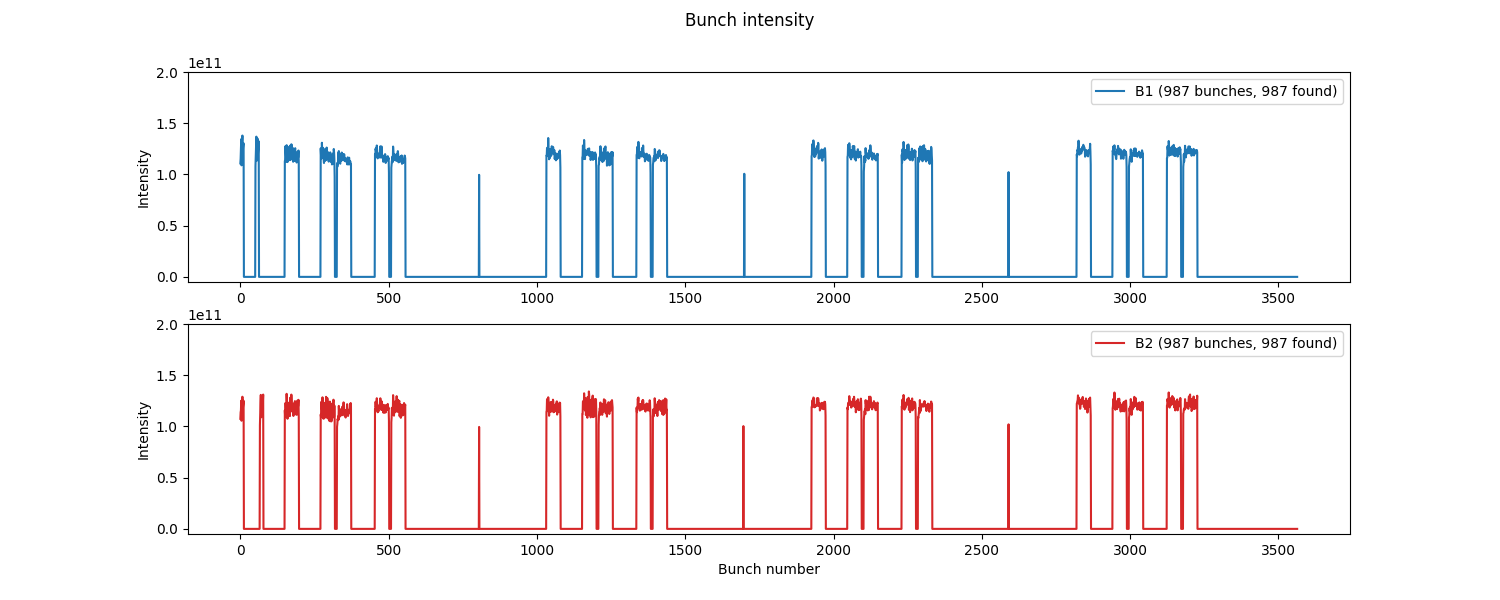

In [3]:
fig, axes = plt.subplots(figsize= (FIGWIDTH,6),ncols=1, nrows=2,gridspec_kw={'height_ratios': [1, 1]})

for beam,ax,color in zip(beams,axes,['C0','C3']):
    
    filled_ts = np.min(database[database[beam['Intensity']]== np.max(database[beam['Intensity']])].index)
    
    sub = database.dropna(subset=[beam['Nb']])
    _ts = sub.index[sub.index.get_loc(filled_ts, method='nearest')]
    Nb        = int(database.loc[_ts,beam['Nb']])

    sub = database.dropna(subset=[beam['bb_Intensity']])
    _ts = sub.index[sub.index.get_loc(filled_ts, method='nearest')]
    bunch_I   = database.loc[_ts,beam['bb_Intensity']]
    
    Nb_found = np.sum(bunch_I>0.5e11)

    plt.sca(ax)
    plt.plot(bunch_I,color=color,label = f'{beam.name} ({Nb} bunches, {Nb_found} found)')
    plt.legend()
    plt.ylim([-0.05e11,2e11])
    plt.ylabel('Intensity')
fig.suptitle('Bunch intensity')
plt.xlabel('Bunch number')


# ROI (Luminosity on)

2022-07-23 12:20:05.629684+00:00 | 2022-07-23 21:24:13.371950+00:00


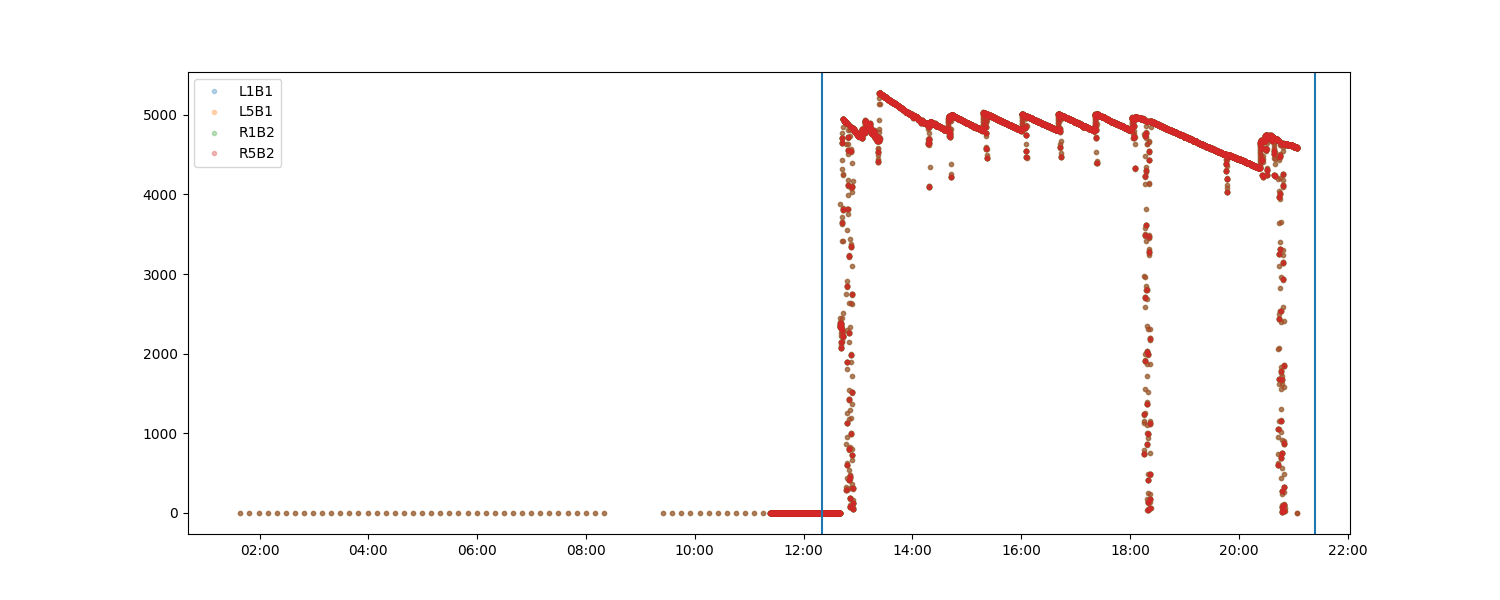

In [4]:
df = database.dropna(subset=[beams[0]['Luminosity']['ATLAS']])

start_ts = df[df[beams[0]['Luminosity']['ATLAS']]>1000]['Timestamp'].min()
stop_ts  = df[df[beams[0]['Luminosity']['ATLAS']]>1000]['Timestamp'].max()

start_ts,stop_ts = start_ts-pd.Timedelta(minutes=20),stop_ts+pd.Timedelta(minutes=20)
print(start_ts,'|',stop_ts)

plt.figure(figsize=(FIGWIDTH,6))
for wire in wires['B1']+wires['B2']:
    database.nxPlot('Timestamp',beams[0]['Luminosity']['ATLAS'],'.',alpha=0.3,label=wire.loc)
plt.axvline(start_ts)
plt.axvline(stop_ts)
plt.legend()

# Luminosity

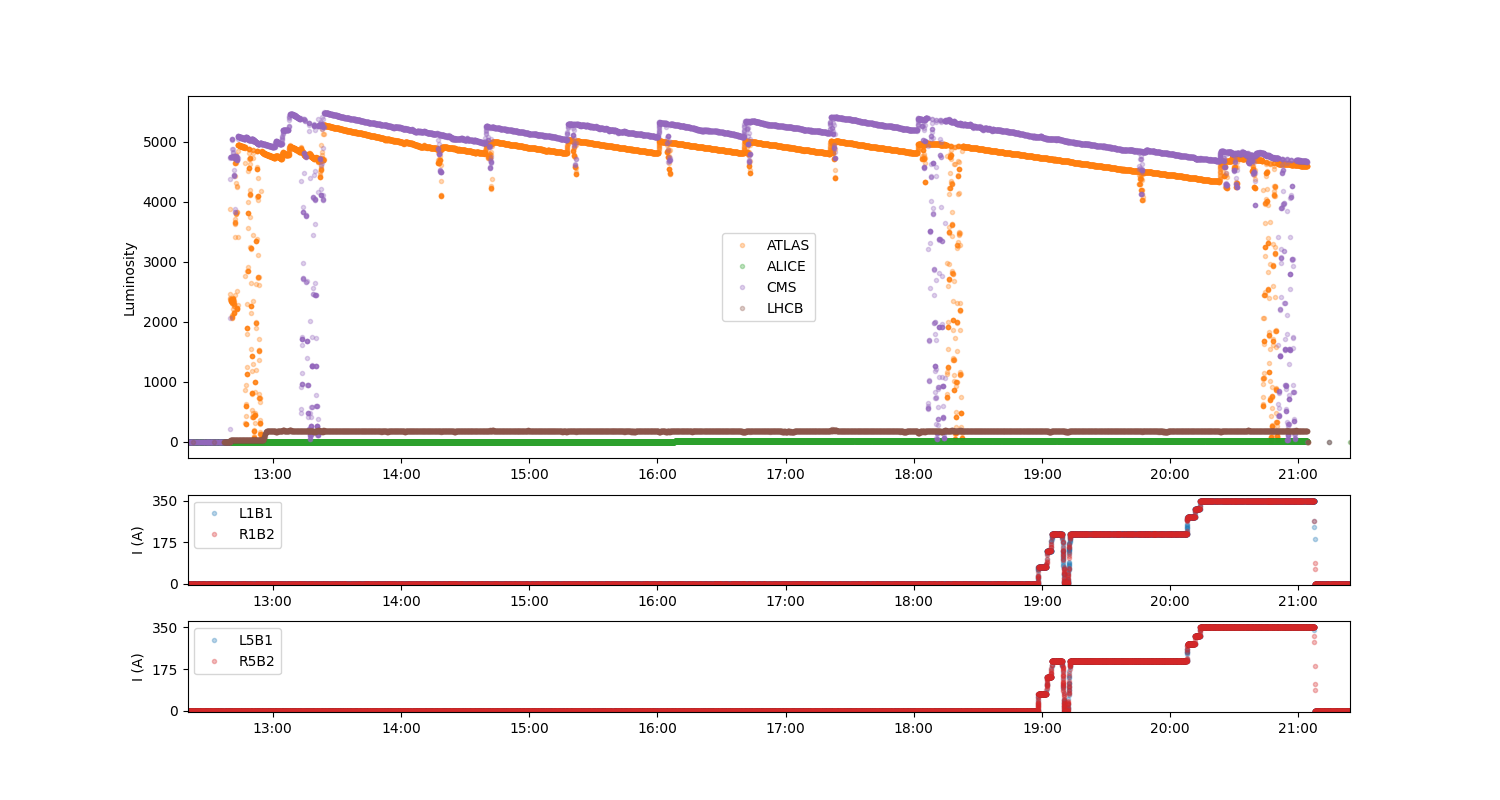

In [5]:



#------------------------------------------
def Make_Wire_Fig(figsize= (6,4)):
    fig, _axes = plt.subplots(figsize=figsize,ncols=1, nrows=3,gridspec_kw={'height_ratios': [4,1, 1]})

    axes = {'IP1':_axes[1],
			'IP5':_axes[2],
            'main':_axes[0]}

    # Taking away blue and red colors
    axes['main'].set_prop_cycle(color= ['#ff7f0e', '#2ca02c', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'])
    
    return fig,axes
#------------------------------------------

# Fig Content
fig,axes = Make_Wire_Fig(figsize=(FIGWIDTH,8))

plt.sca(axes['main'])
for loc in ['ATLAS','ALICE','CMS','LHCB']:
    database.nxPlot('Timestamp',beams[0]['Luminosity'][loc],'.',alpha=0.3,label=loc)
plt.ylabel('Luminosity')


for _IP in ['IP1','IP5']:
    plt.sca(axes[_IP])
    for wire,color in zip(wires['B1']+wires['B2'],['C0','C0','C3','C3']):
        if wire.loc[1] == _IP[-1]:
            database.nxPlot('Timestamp',wire['I'],'.',alpha=0.3,color=color,label=wire.loc)
    plt.ylim([-5,375])
    plt.yticks([0,175,350])
    plt.ylabel('I (A)')

for ax in axes.values():
    plt.sca(ax)
    plt.legend()
    plt.xlim([start_ts,stop_ts])

# Lifetime vs Intensity

/home/phbelang/abp/WireDAQ/acc-py/base/2020.11/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/phbelang/abp/WireDAQ/acc-py/base/2020.11/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


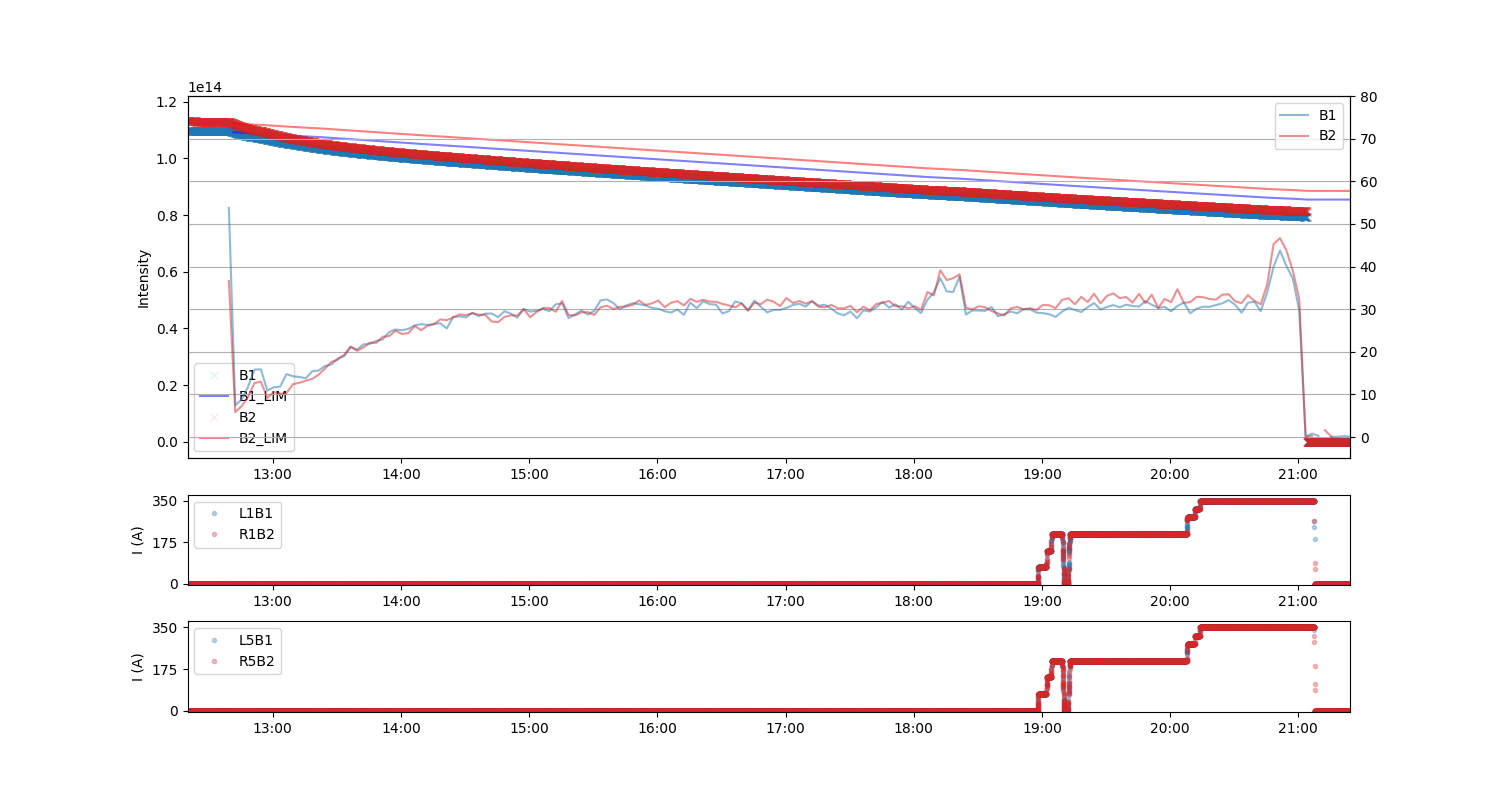

In [6]:
from scipy.optimize import curve_fit

def compute_lifetime(df,beam,window=5*60):
    
    # Fitting Intensity to the following:
    # N(t) = N0/(1+t/tau), tau-> lifetime

    # GROUPING DATA IN TIME WINDOWS
    sub = df.dropna(subset=[beam['Intensity']])
    grouped = sub.groupby(pd.cut(sub['Time'],bins=np.arange(sub.iloc[0]['Time'],sub.iloc[-1]['Time'],window)))
    
    # COMPUTING FIT FOR EACH WINDOW
    fit_df = grouped.apply(lambda data: curve_fit(lambda _t,tau :data.iloc[0][beam['Intensity']]/(1+(_t-data.iloc[0]['Time'])/tau), data['Time'], data[beam['Intensity']]))
    
    # UNPACKING RESULTS
    bin_time      = np.array(pd.Series(fit_df.index).apply(lambda line:line.mid))
    bin_unix      = (bin_time - sub.iloc[0]['Time'])*1e9 + sub.index[0]
    bin_timestamp = [pd.Timestamp(t).tz_localize('UTC') for t in bin_unix]
    bin_lifetime  = np.array(fit_df.apply(lambda line:line[0][0]))

    # DELETING UNPHYSICAL LIFETIMES
    bin_lifetime[bin_lifetime/3600>150] = np.nan

    return pd.DataFrame({'unix':bin_unix,'Timestamp':bin_timestamp,'Time':bin_time,'Lifetime':bin_lifetime})


# COMPUTING LUMI TOT
#============================
try:
    database.insert(4,'LUMI_TOT',database[beams[0]['Luminosity']['ATLAS']])
except:
    database['LUMI_TOT'] = database[beams[0]['Luminosity']['ATLAS']].copy()

for loc in ['ALICE','CMS','LHCB']:
    times = database[beams[0]['Luminosity']['ATLAS']].dropna().index
    database.loc[times,'LUMI_TOT'] += np.interp(times, database[beams[0]['Luminosity'][loc]].dropna().index,database[beams[0]['Luminosity'][loc]].dropna())
#============================

# COMPUTING INTENSITY LIMIT
#============================
try:
    for beam in beams:
        database.insert(4,f'INT_LIM_{beam.name}',np.nan)
except:
    for beam in beams:
        database[f'INT_LIM_{beam.name}'] = np.nan

# Adding upper bound of intensity
for beam in beams:
    sub   = database.dropna(subset=[beam['Intensity']])
    
    sig_c = 80e-3
    
    L     = np.interp(sub[beam['Intensity']].index, database['LUMI_TOT'].dropna().index,database['LUMI_TOT'].dropna())   
    dNdt  = -L*1e6*sig_c

    unix_stable = database[database['HX:BMODE'] == 'STABLE'].index[0]
    N0_loc = np.argmin(np.abs(sub.index -unix_stable))
    tVec   = (sub[beam['Intensity']].index[N0_loc:])*1e-9
    N      = sub.iloc[N0_loc][beam['Intensity']] + np.cumsum(dNdt[N0_loc:-1]*np.diff(tVec))
    database.loc[sub.index[N0_loc:-1],f'INT_LIM_{beam.name}'] = N
#============================

# Fig Content
fig,axes = Make_Wire_Fig(figsize=(FIGWIDTH,8))

plt.sca(axes['main'])
for beam,color,color2 in zip(beams,['C0','C3'],['b','r']):
    database.nxPlot('Timestamp',beam['Intensity'],'x',alpha=0.1,color=color,label=beam.name)

    database.nxPlot('Timestamp',f'INT_LIM_{beam.name}','-',alpha=0.5,color=color2,label=beam.name + '_LIM')
    


plt.ylabel('Intensity')

# Plotting lifetime
axRight = axes['main'].twinx()
for beam,color in zip(beams,['C0','C3']):
    result_df = compute_lifetime(database,beam,window=3*60)
    plt.plot(result_df['Timestamp'],result_df['Lifetime']/3600,'-',color=color,alpha=0.5,label=beam.name)
plt.ylim([-5,80])
plt.legend()
plt.grid(axis='y')


for _IP in ['IP1','IP5']:
    plt.sca(axes[_IP])
    for wire,color in zip(wires['B1']+wires['B2'],['C0','C0','C3','C3']):
        if wire.loc[1] == _IP[-1]:
            database.nxPlot('Timestamp',wire['I'],'.',alpha=0.3,color=color,label=wire.loc)
    plt.ylim([-5,375])
    plt.yticks([0,175,350])
    plt.ylabel('I (A)')

for ax in axes.values():
    plt.sca(ax)
    plt.legend()
    plt.xlim([start_ts,stop_ts])



# Lifetime vs Lumi Limit

/home/phbelang/abp/WireDAQ/acc-py/base/2020.11/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/phbelang/abp/WireDAQ/acc-py/base/2020.11/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


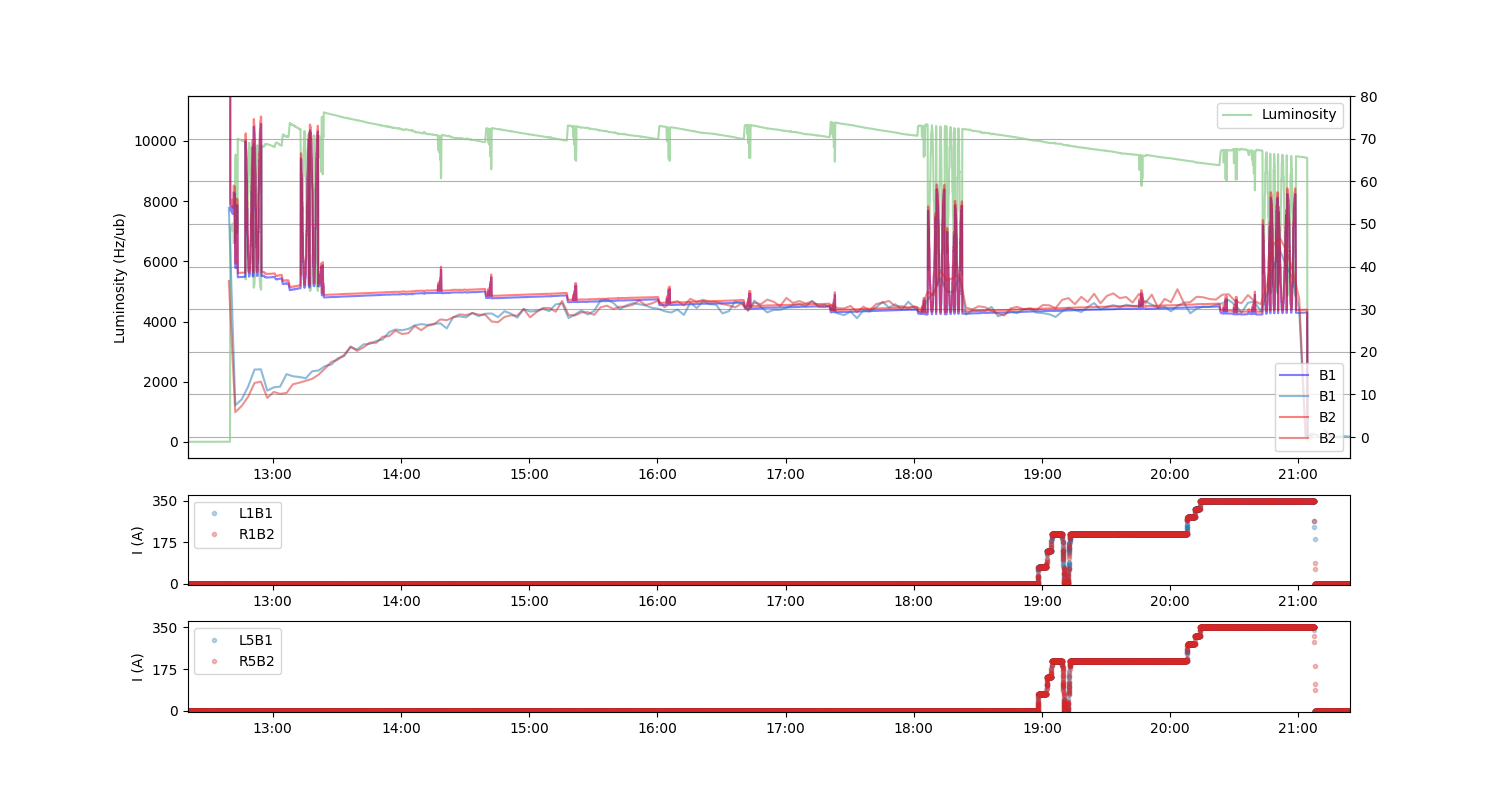

In [7]:


# Fig Content
fig,axes = Make_Wire_Fig(figsize=(15,8))
plt.sca(axes['main'])
database.nxPlot('Timestamp','LUMI_TOT',alpha=0.4,color='C2',label='Luminosity')
plt.ylabel('Luminosity (Hz/ub)')
#axes['main'].legend(loc='upper right')

axRight = axes['main'].twinx()
for beam,color,color2 in zip(beams,['C0','C3'],['b','r']):
    sig_c = 80e-3
    
    # Interpolating intensity
    times = database['LUMI_TOT'].dropna().index
    N     = np.interp(times, database[beam['Intensity']].dropna().index,database[beam['Intensity']].dropna())
    L     = database['LUMI_TOT'].dropna()
    tau   = N/(L*1e6*sig_c)

    timestamp = database.dropna(subset=['LUMI_TOT'])['Timestamp']

    plt.plot(timestamp,tau/3600,color=color2,alpha=0.5,label=beam.name)

    result_df = compute_lifetime(database,beam,window=3*60)
    plt.plot(result_df['Timestamp'],result_df['Lifetime']/3600,'-',color=color,alpha=0.5,label=beam.name)

plt.legend(loc='lower right')
plt.ylim([-5,80])
plt.grid(axis='y')




for _IP in ['IP1','IP5']:
    plt.sca(axes[_IP])
    for wire,color in zip(wires['B1']+wires['B2'],['C0','C0','C3','C3']):
        if wire.loc[1] == _IP[-1]:
            database.nxPlot('Timestamp',wire['I'],'.',alpha=0.3,color=color,label=wire.loc)
    plt.ylim([-5,375])
    plt.yticks([0,175,350])
    plt.ylabel('I (A)')

for ax in axes.values():
    plt.sca(ax)
    plt.legend()
    plt.xlim([start_ts,stop_ts])


# Cross section

/home/phbelang/abp/WireDAQ/py_wireDAQ/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in double_scalars
/home/phbelang/abp/WireDAQ/py_wireDAQ/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: divide by zero encountered in true_divide
/home/phbelang/abp/WireDAQ/acc-py/base/2020.11/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/phbelang/abp/WireDAQ/py_wireDAQ/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in double_scalars
/home/phbelang/abp/WireDAQ/py_wireDAQ/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: divide by zero encountered in true_divide
/home/phbelang/abp/WireDAQ/acc-py/base/2020.11/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=Optim

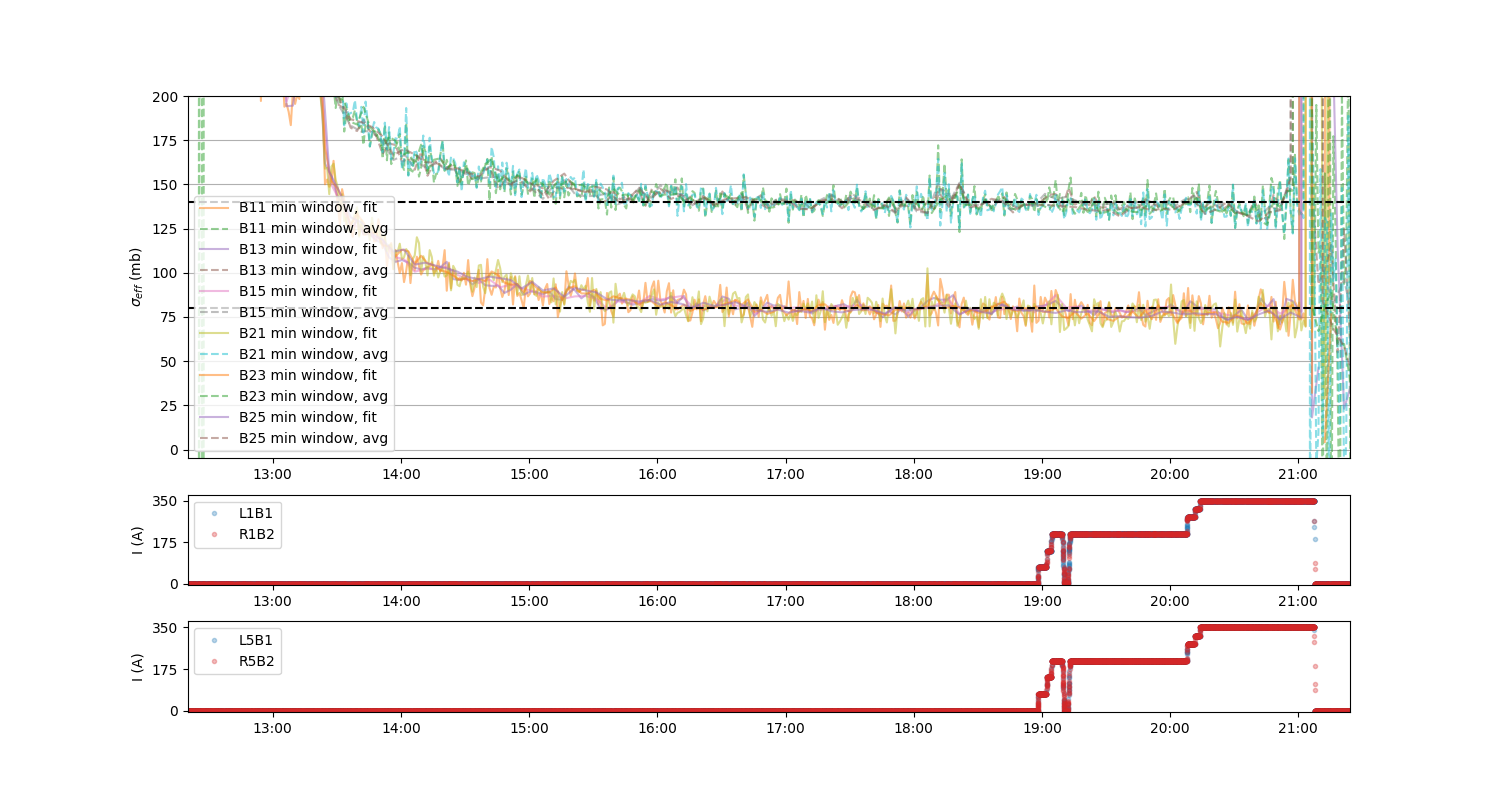

In [9]:
def compute_xsection_fit(df,beam,window=5*60):
    
    # Fitting Intensity to the following:
    # N(t) = N0/(1+t/tau), tau-> lifetime

    # GROUPING DATA IN TIME WINDOWS
    sub     = df.dropna(subset=[beam['Intensity']]).copy()
    grouped = sub.groupby(pd.cut(sub['Time'],bins=np.arange(sub.iloc[0]['Time'],sub.iloc[-1]['Time'],window)))
    sub.loc[:,'LUMI_TOT'] = np.interp(sub[beam['Intensity']].index, database['LUMI_TOT'].dropna().index,database['LUMI_TOT'].dropna())   

    # COMPUTING FIT FOR EACH WINDOW
    fit_df = grouped.apply(lambda data: curve_fit(lambda _t,tau :data.iloc[0][beam['Intensity']]/(1+(_t-data.iloc[0]['Time'])/tau), data['Time'], data[beam['Intensity']]))
    
    # UNPACKING RESULTS
    bin_time      = np.array(pd.Series(fit_df.index).apply(lambda line:line.mid))
    bin_unix      = (bin_time - sub.iloc[0]['Time'])*1e9 + sub.index[0]
    bin_timestamp = [pd.Timestamp(t).tz_localize('UTC') for t in bin_unix]
    bin_lifetime  = np.array(fit_df.apply(lambda line:line[0][0]))
    
    # DELETING UNPHYSICAL LIFETIMES
    bin_lifetime[bin_lifetime/3600>150] = np.nan

    # Computing cross section
    bin_xsection  = grouped.apply(lambda data: data.iloc[0][beam['Intensity']]/np.mean(1e6*data['LUMI_TOT']))/bin_lifetime


    return pd.DataFrame({'unix':bin_unix,'Timestamp':bin_timestamp,'Time':bin_time,'Lifetime':bin_lifetime,'sig_c':bin_xsection})


def compute_xsection_avg(df,beam,window=5*60):
    # GROUPING DATA IN TIME WINDOWS
    sub     = database.dropna(subset=[beam['Intensity']]).copy()
    grouped = sub.groupby(pd.cut(sub['Time'],bins=np.arange(sub.iloc[0]['Time'],sub.iloc[-1]['Time'],window)))
    sub.loc[:,'LUMI_TOT'] = np.interp(sub[beam['Intensity']].index, database['LUMI_TOT'].dropna().index,database['LUMI_TOT'].dropna())   

    # AVG in each time window
    bin_time  = np.array(pd.Series(grouped.groups.keys()).apply(lambda line:line.mid))
    dNdt      = np.diff(grouped[beam['Intensity']].mean())/np.diff(bin_time)
    L         = np.array(1e6*grouped['LUMI_TOT'].mean())[:-1]

    # Computing cross section
    bin_xsection  = -dNdt/L


    # UNPACKING RESULTS
    bin_unix      = (bin_time - sub.iloc[0]['Time'])*1e9 + sub.index[0]
    bin_timestamp = [pd.Timestamp(t).tz_localize('UTC') for t in bin_unix]
    

    return pd.DataFrame({'unix':bin_unix[:-1],'Timestamp':bin_timestamp[:-1],'Time':bin_time[:-1],'sig_c':bin_xsection})



# Fig Content
fig,axes = Make_Wire_Fig(figsize=(15,8))


plt.sca(axes['main'])
for beam,color,color2 in zip(beams,['C0','C3'],['b','r']):
    for wind in [1,3,5]:
        result_df = compute_xsection_fit(database,beam,window=wind*60)
        result_df2 = compute_xsection_avg(database,beam,window=wind*60)

        plt.plot(result_df['Timestamp'],result_df['sig_c']/1e-3,'-',alpha=0.5,label=beam.name+f'{wind} min window, fit')
        plt.plot(result_df2['Timestamp'],60+result_df2['sig_c']/1e-3,'--',alpha=0.5,label=beam.name+f'{wind} min window, avg')

plt.legend(loc='lower right')
plt.ylabel(r'$\sigma_{eff}$ (mb)')
plt.axhline(80,ls='--',color='k')
plt.axhline(140,ls='--',color='k')
plt.ylim([-5,200])
plt.grid(axis='y')




for _IP in ['IP1','IP5']:
    plt.sca(axes[_IP])
    for wire,color in zip(wires['B1']+wires['B2'],['C0','C0','C3','C3']):
        if wire.loc[1] == _IP[-1]:
            database.nxPlot('Timestamp',wire['I'],'.',alpha=0.3,color=color,label=wire.loc)
    plt.ylim([-5,375])
    plt.yticks([0,175,350])
    plt.ylabel('I (A)')

for ax in axes.values():
    plt.sca(ax)
    plt.legend()
    plt.xlim([start_ts,stop_ts])
    